# Introduction


In this notebook, we will explore how to build a machine learning model for classifying images using PyTorch, a widely used and adopted deep learning library for production and research. PyTorch has become a popular choice among researchers and machine learning practitioners because of its dynamic approach and flexibility for building and training complex models.

One of the distinct advantages of PyTorch is its focus on **dynamic programming**. Unlike some other deep learning libraries, PyTorch allows you to build and modify computational graphs on the fly, providing great flexibility for designing models and performing interactive experiments. In addition, PyTorch has a **large user community and detailed documentation**, making it easy to learn and troubleshoot.

Throughout this notebook, we will discover how to take full advantage of PyTorch's capabilities to build, train and evaluate our image classification model. From data preparation to implementing optimization techniques, we will explore the essential fundamentals so that you can develop your skills in the exciting field of machine learning with PyTorch. This notebook follows a basic machine learning workflow

### Index
1. Data structure in Pytorch: Tensors 
2. Data Loading and Visualization: CIFAR10
3. Define a Convolutional Neural Network
4. Define a loss function
5. Train the network on the training data
6. Test the network on the test data


In [1]:
#@title load libraries

import time
import random

import torch
import torchvision
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [38]:
#@title utilities


def load_data(batch_size=512, pre_load=True):
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
  testloader = torch.utils.data.DataLoader(testset, batch_size=1024, shuffle=False)

  if pre_load:
    train_data = [ sample for sample in trainloader ]
    test_data  = [ sample for sample in testloader  ]
    return train_data, test_data
  return trainloader, testloader

class AverageMeter(object):
  '''A handy class from the PyTorch ImageNet tutorial'''
  def __init__(self):
    self.reset()

  def __str__(self):
    return f"{self.avg}"

  def reset(self):
    self.vals, self.avg, self.sum, self.count = [], 0, 0, 0

  def update(self, val, n=1):
    self.vals.append(val)
    self.sum += val * n
    self.count += n
    self.avg = self.sum / self.count

# top1 accuracy
def accuracy(output, target, topk=(1,)):
    '''Computes the accuracy over the k top predictions for the specified values of k'''
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()

        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))

        return res


def acc_barplot(history, ax, xlabel=None):
    """
    this function plots the training and testing history for n models in a barplot

    Parameters:
    -----------
    history: numpy array
        list of training history for n models, each model is a dictionary with keys 'loss', 'acc', 'val_loss', 'val_acc', 'name'
        each model must have the same number of epochs and metrics
    """

    ax.set_xlabel('Models') if xlabel is None else ax.set_xlabel(xlabel)
    ax.set_ylabel('Accuracy')
    ax.set_title('Accuracy of Models (Train vs Test)')



    models = [ f'{e["name"]}' for i, e in enumerate(history) ]
    #check repeated name values
    models = [ models[i] + '_' if models[i] in models[:i] else models[i] for i in range(len(models)) ]

    accs = [ model['acc'][-1] for model in history ]
    val_accs = [ model['val_acc'][-1] for model in history ]
    acc = accs + val_accs

    ax.set_ylim (min(acc) - 10, max(acc) + 5)

    hue_labels = ['train'] * len(accs) + ['test'] * len(val_accs)

    sns.set(style="whitegrid")
    sns.barplot(x=models * 2, y=acc, hue=hue_labels, ax=ax)

def batch_lineplot(history, ax, acc = True):
    """
    This function plots the training and testing history for n models

    Parameters:
    ----------
    history: numpy array
        list of training history for n models, each model is a dictionary with keys 'loss', 'acc', 'val_loss', 'val_acc', 'name'
        each model must have the same number of epochs and metrics

    """

    plt.gca().set_prop_cycle(None)
    ax.set_xlabel('Batch')
    ax.set_ylabel('Accuracy') if acc else ax.set_ylabel('Loss')
    ax.set_title('Accuracy of Models (Train vs Test)') if acc else ax.set_title('Loss of Models (Train vs Test)')

    metric = 'acc' if acc else 'loss'
    val_metric = 'val_acc' if acc else 'val_loss'

    metrics = [ model[metric] for model in history ]

    val_metrics = [ model[val_metric] for model in history ]

    sns.set(style="whitegrid")

    for i,acc in enumerate(metrics):
        sns.lineplot(x=range(len(acc)), y=acc, label=f'{history[i]["name"]}', ax=ax)

    ax.set_prop_cycle(None)

    for i, val_acc in enumerate(val_metrics):
        sns.lineplot(x=range( len(metrics[0])//(len(val_metrics[i])), len(metrics[0])+1, len(metrics[0])//(len(val_metrics[i]))), y=val_acc
                     , marker='o', markersize=7, linestyle='--',  ax=ax)


def plot_tensor_resul(tensor_a, tensor_b, resul, label_resul=""):
    plt.subplot(1, 3, 1)
    plt.title("a")
    plt.imshow(tensor_a, cmap="Pastel2")
    plt.xticks([])
    plt.yticks([])
    # display values as text inside the matrix
    for (i, j), z in np.ndenumerate(tensor_a):
        plt.text(j, i, '{}'.format(z), ha='center', va='center')


    plt.subplot(1, 3, 2)
    plt.title("b")
    plt.imshow(tensor_b, cmap="Pastel2")
    plt.xticks([])
    plt.yticks([])
    for (i, j), z in np.ndenumerate(tensor_b):
        plt.text(j, i, '{}'.format(z), ha='center', va='center')


    plt.subplot(1, 3, 3)
    plt.title(label_resul)
    plt.imshow(a_plus_b, cmap="Pastel2")
    plt.xticks([])
    plt.yticks([])
    for (i, j), z in np.ndenumerate(resul):
        plt.text(j, i, '{}'.format(z), ha='center', va='center')

    plt.show()
  


### 1. Data structure in Pytorch: Tensors


<div align="center"><img src="https://miro.medium.com/v2/resize:fit:880/1*WbLIc4-xIOfHiO2oWzimyA.png" width="700"></div>


In pytorch, tensors are the main data structure. They are similar to numpy arrays, but they can be used on GPU to accelerate computing. 
There are several ways to create tensors in pytorch. 

1. From a list or numpy array
2. From a random number generator
3. From a file





In [4]:
# 1.1 Create a tensor from a list

data = [
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9]
]

tensor_from_list = torch.tensor(data, dtype=torch.int32)
print(tensor_from_list)

tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]], dtype=torch.int32)


In [5]:
# 1.2. Create a tensor from a numpy array

data = np.array([
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9]
])

tensor_from_numpy = torch.from_numpy(data, dtype=torch.int32)
print(tensor_from_numpy)

tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]], dtype=torch.int32)


In [7]:
# 2. Create a tensor from a random number generator

tensor_randn = torch.randint(3, 10, (3, 3), dtype=torch.int32)

print(tensor_randn)


tensor([[7, 7, 4],
        [7, 6, 9],
        [6, 3, 3]], dtype=torch.int32)


The tensors in pytorch have various attributes, where its most important attributes are:

- shape: the shape of the tensor (number of dimensions and number of elements in each dimension) and can be accessed by `tensor.shape()` or `tensor.size()`
- dtype: the data type of the tensor (float, int, etc.) and can be accessed by `tensor.dtype`
- device: the device where the tensor is stored (CPU or GPU) and can be accessed by `tensor.device`

In [9]:
# Display main attributes of a tensor

tensor = torch.rand(3, 4)

print("tensor: ", tensor)
print("tensor.shape: ", tensor.shape)
print("tensor.dtype: ", tensor.dtype)
print("tensor.device: ", tensor.device)

tensor:  tensor([[0.4593, 0.4252, 0.9396, 0.1151],
        [0.0538, 0.6050, 0.0988, 0.0709],
        [0.6385, 0.9738, 0.0058, 0.0702]])
tensor.shape:  torch.Size([3, 4])
tensor.dtype:  torch.float32
tensor.device:  cpu


## 1. Basics algebraic operations with PyTorch tensors

1. Addition of two tensors
2. Element-wise multiplication of two tensors
3. Matrix multiplication
4. Dot product


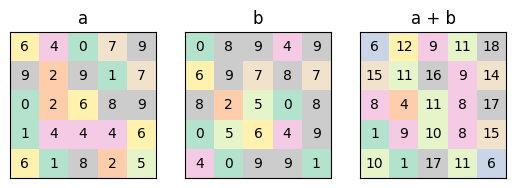

In [39]:
#@title Addition of two tensors

tensor_a = torch.randint(0, 10, (5, 5))
tensor_b = torch.randint(0, 10, (5, 5))

# 1. Addition of two tensors
a_plus_b = tensor_a + tensor_b

# visualizing the addition with matplotlib
plot_tensor_resul(tensor_a, tensor_b, a_plus_b, "a + b")

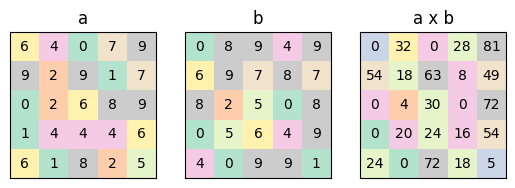

In [40]:
#@title Elementwise multiplication of two tensors

a_times_b = torch.mul(tensor_a, tensor_b)
plot_tensor_resul(tensor_a, tensor_b, a_times_b, "a x b")

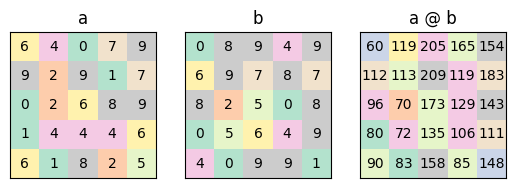

In [41]:
#@title matrix multiplication

a_matmul_b = torch.matmul(tensor_a, tensor_b)
plot_tensor_resul(tensor_a, tensor_b, a_matmul_b, "a @ b")

### 2. Data Loading and Visualization: CIFAR10

Embrace the power of data, for it holds the key to unlocking the true potential of Artificial Intelligence. In the ever-evolving landscape of technology, the surge of data in the last decades has been truly remarkable. With each passing year, there has been an explosive growth in the volume, velocity, and variety of data generated by individuals, businesses, and connected devices. This data deluge has become the fuel that propels the engine of AI forward, driving it to new heights of innovation and discovery.

As data is loaded into the algorithms, it breathes life into the machine, granting it the ability to learn, adapt, and transform the world. Each data point represents a valuable piece of knowledge, and every dataset becomes a rich tapestry of information. The challenges of preprocessing and organizing the data are to be approached with determination, for with each step, AI gains the power to revolutionize industries, solve complex problems, and make a profound impact on humanity.

Fortunately, PyTorch has different tools for that, such as:
1. [torchvision](https://pytorch.org/vision/stable/index.html) Library:
 Is a part of PyTorch that provides popular datasets, model architectures, and various image transformation functions for computer vision tasks.

2. [torchvision.datasets](https://pytorch.org/vision/stable/datasets.html): This submodel within torchvision porvides functions to create and load popular datasets, such as CIFAR-10, MNIST, and ImageNet. (In this notebook is used the CIFAR-10 dataset.)
3. [torchvision.transforms](https://pytorch.org/vision/stable/transforms.html) module: This module contains various image transformation functions that help in pre-processing the dataset before feeding it to a neural network.

(optional to explain)

$$
\textbf{x}'=\frac{\textbf{x}-min(\textbf{x})}{max(\textbf{x})-min(\textbf{x})}
$$





In [ ]:
#@title Load  Cifar10 dataset

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#  Data Transformation:
#  Define the transformation pipeline for data preprocessing.
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,))
])

#  Load Training Data:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

#  Create a DataLoader for training data:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True)

#  Load Test Data:
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

#  Create a DataLoader for test data:
testloader = torch.utils.data.DataLoader(testset, batch_size=1024, shuffle=False)

#  Preload Data:

train_data = [ sample for sample in trainloader ]
test_data  = [ sample for sample in testloader  ]

100%|██████████| 170498071/170498071 [00:05<00:00, 29626120.22it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### 2. Data Visualization

Before training a neural network, it is essential to comprehend the data being used. Data visualization allos exploring the structure, distribution, and patterns present in the data. This helps to detect possible anomalies, imbalances, or noise that could affect the performance of the network. Also, datavisualization can help identify the need for certain transformations or preprocessing steps before feeding the data to the neural network. For example, normalizing features.

The CIFAR-10 dataset consists of 60000 colour images $\textbf{x}$ of size 32x32 size in 10 classes $\textbf{y}$; the dataset's classes include: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck. Each class contains 6000 images. There are 50000 training images and 10000 test images.

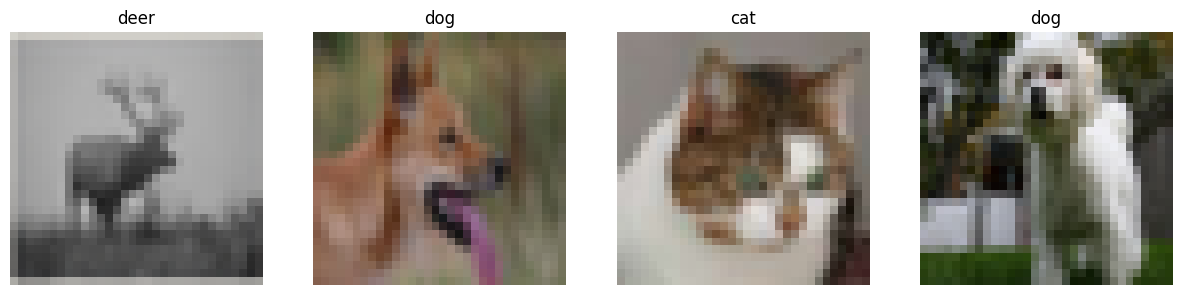

In [ ]:
#@title Visualize data with labels

# Define the class names for CIFAR-10 dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0)).astype(np.float32)

# Get a batch of random training images and their corresponding labels
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Visualize the images with labels
fig, axs = plt.subplots(1, 4, figsize=(15, 5))

for image, i in zip(images, range(4)):

    # show images
    image = imshow(image)
    axs[i].imshow(image)
    axs[i].set_title(classes[labels[i]])
    axs[i].axis('off')


## 3. Convolutional Neural Network



important to consider:

1. [nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html)

--------------------


Al definir el una arquitectura de red neural se emplean 3 componentes principales

* Capa de entrada: El modelo recibe de entrada la imagen $\textbf{x}$
* Capas ocultas: Diferentes capas lineales y no lineas que extraen caracteristicas de la imagen
* Capa de salida: Funcion de activación para realizar la predición de un tarea especifica (regresion, clasificación) $\textbf{y}$





<div align="center"><img src="https://neurohive.io/wp-content/uploads/2018/11/vgg16-1-e1542731207177.png" width="700"></div>


The hidden layer in model can be different types of linear and non-linear mathematical functions, in the case of the proposed architecture, the model consists of the following components:

`Input Layer`: Accepts 3-channel (RGB) images as input.

`Convolutional Layers`: The network starts with a convolutional layer called [Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) followed by [batch normalization](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html). Then, a configurable number of additional convolutional layers are added, each followed by batch normalization and a [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html?highlight=relu) activation function. These layers capture hierarchical features from the input images.

`Max Pooling`: After each convolutional layer, [max pooling](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) is performed to downsample the feature maps, reducing their spatial dimensions.

`Flattening`: The feature maps are flattened into a 1D vector to be processed by the fully connected layers.

`Fully Connected Layers`: A single [fully connected layer](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) is added, which takes the flattened feature vector as input. The output size of this layer is determined by the number of target classes (in this case, 10 classes).

`Last Activation`: The fully connected layer is followed by a [softmax](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html?highlight=softmax) activation function to obtain class probabilities.


### Defined Convolutional Neural Network

Finally, the entery process that perform the convolutionl neural network can be mathematically defines as


$$
\hat{\textbf{y}} = \mathcal{M}_{\theta} (\textbf{x})
$$

In [ ]:
# Classification model ResNet18 based

import torch.nn as nn

class ClassificationNet(nn.Module):


    # description: what means and what can i do in the __init__ function?
    def __init__(self, features=16, num_layers=4, img_size=32, name="ClassificationNet"):
        super(ClassificationNet, self).__init__()
        self.name = name

        # define layers
        layers = []

        down_factor = 1

        # first layer
        layers.append(nn.Conv2d(3, features, kernel_size=3, stride=1, padding=1, bias=False))
        layers.append(nn.BatchNorm2d(features))

        # hidden layers
        for _ in range(num_layers):
            layers.append(nn.Conv2d(features, features, kernel_size=3, stride=1, padding=1, bias=False))
            layers.append(nn.BatchNorm2d(features))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            down_factor *= 2

        layers.append(nn.Flatten())

        final_size = int(img_size / down_factor)

        # output layer
        layers.append(nn.Linear(features * final_size * final_size, 10))
        layers.append(nn.Softmax(dim=1))

        self.model = nn.Sequential(*layers)

     # description: what means and what can i do in the forward function?
    def forward(self, x):
        return self.model(x)

In [ ]:
# Crear modelo
model = ClassificationNet()

## 4. **Define cost function**: Categorical Cross-Entropy


$$
\mathcal{L}_{ce} = - \sum_{i=1}^C \textbf{y}_i \cdot \log( \hat{\textbf{y}_i})
$$

* $C$ is the number of classes
* $\textbf{y}$ is the true label vector
* $\hat{\textbf{y}}$ is the network prediction, $\hat{\textbf{y}} = \mathcal{M}_\theta(\textbf{x})$


[Loss functions](https://pytorch.org/docs/stable/nn.html#loss-functions)

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
#@title Validation
def validate(test_loader, model, criterion):
    model.eval()

    batch_time, data_time, losses, top1 = AverageMeter(), AverageMeter(), AverageMeter(), AverageMeter()

    end = time.time()

    for i, (image, label) in enumerate(test_loader):

        data_time.update(time.time() - end)

        image, label = image.to(device), label.to(device)

        output = model(image)
        loss = criterion(output, label)
        losses.update(loss.item(), image.size(0))

        # measure accuracy and record loss
        prec1 = accuracy(output.data, label, topk=(1,))[0].item()
        top1.update(prec1, image.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

    print(f'Test: \tTime {batch_time.vals[-1]:.3f} ({batch_time.avg:.3f})\t'
        f'Data {data_time.vals[-1]:.3f} ({data_time.avg:.3f})\t'
        f'Loss {losses.vals[-1]:.4f} ({losses.avg:.4f})\t'
        f'Accuracy {top1.vals[-1]:.3f} ({top1.avg:.3f})')

    return losses.avg, top1.avg

###Training Loop
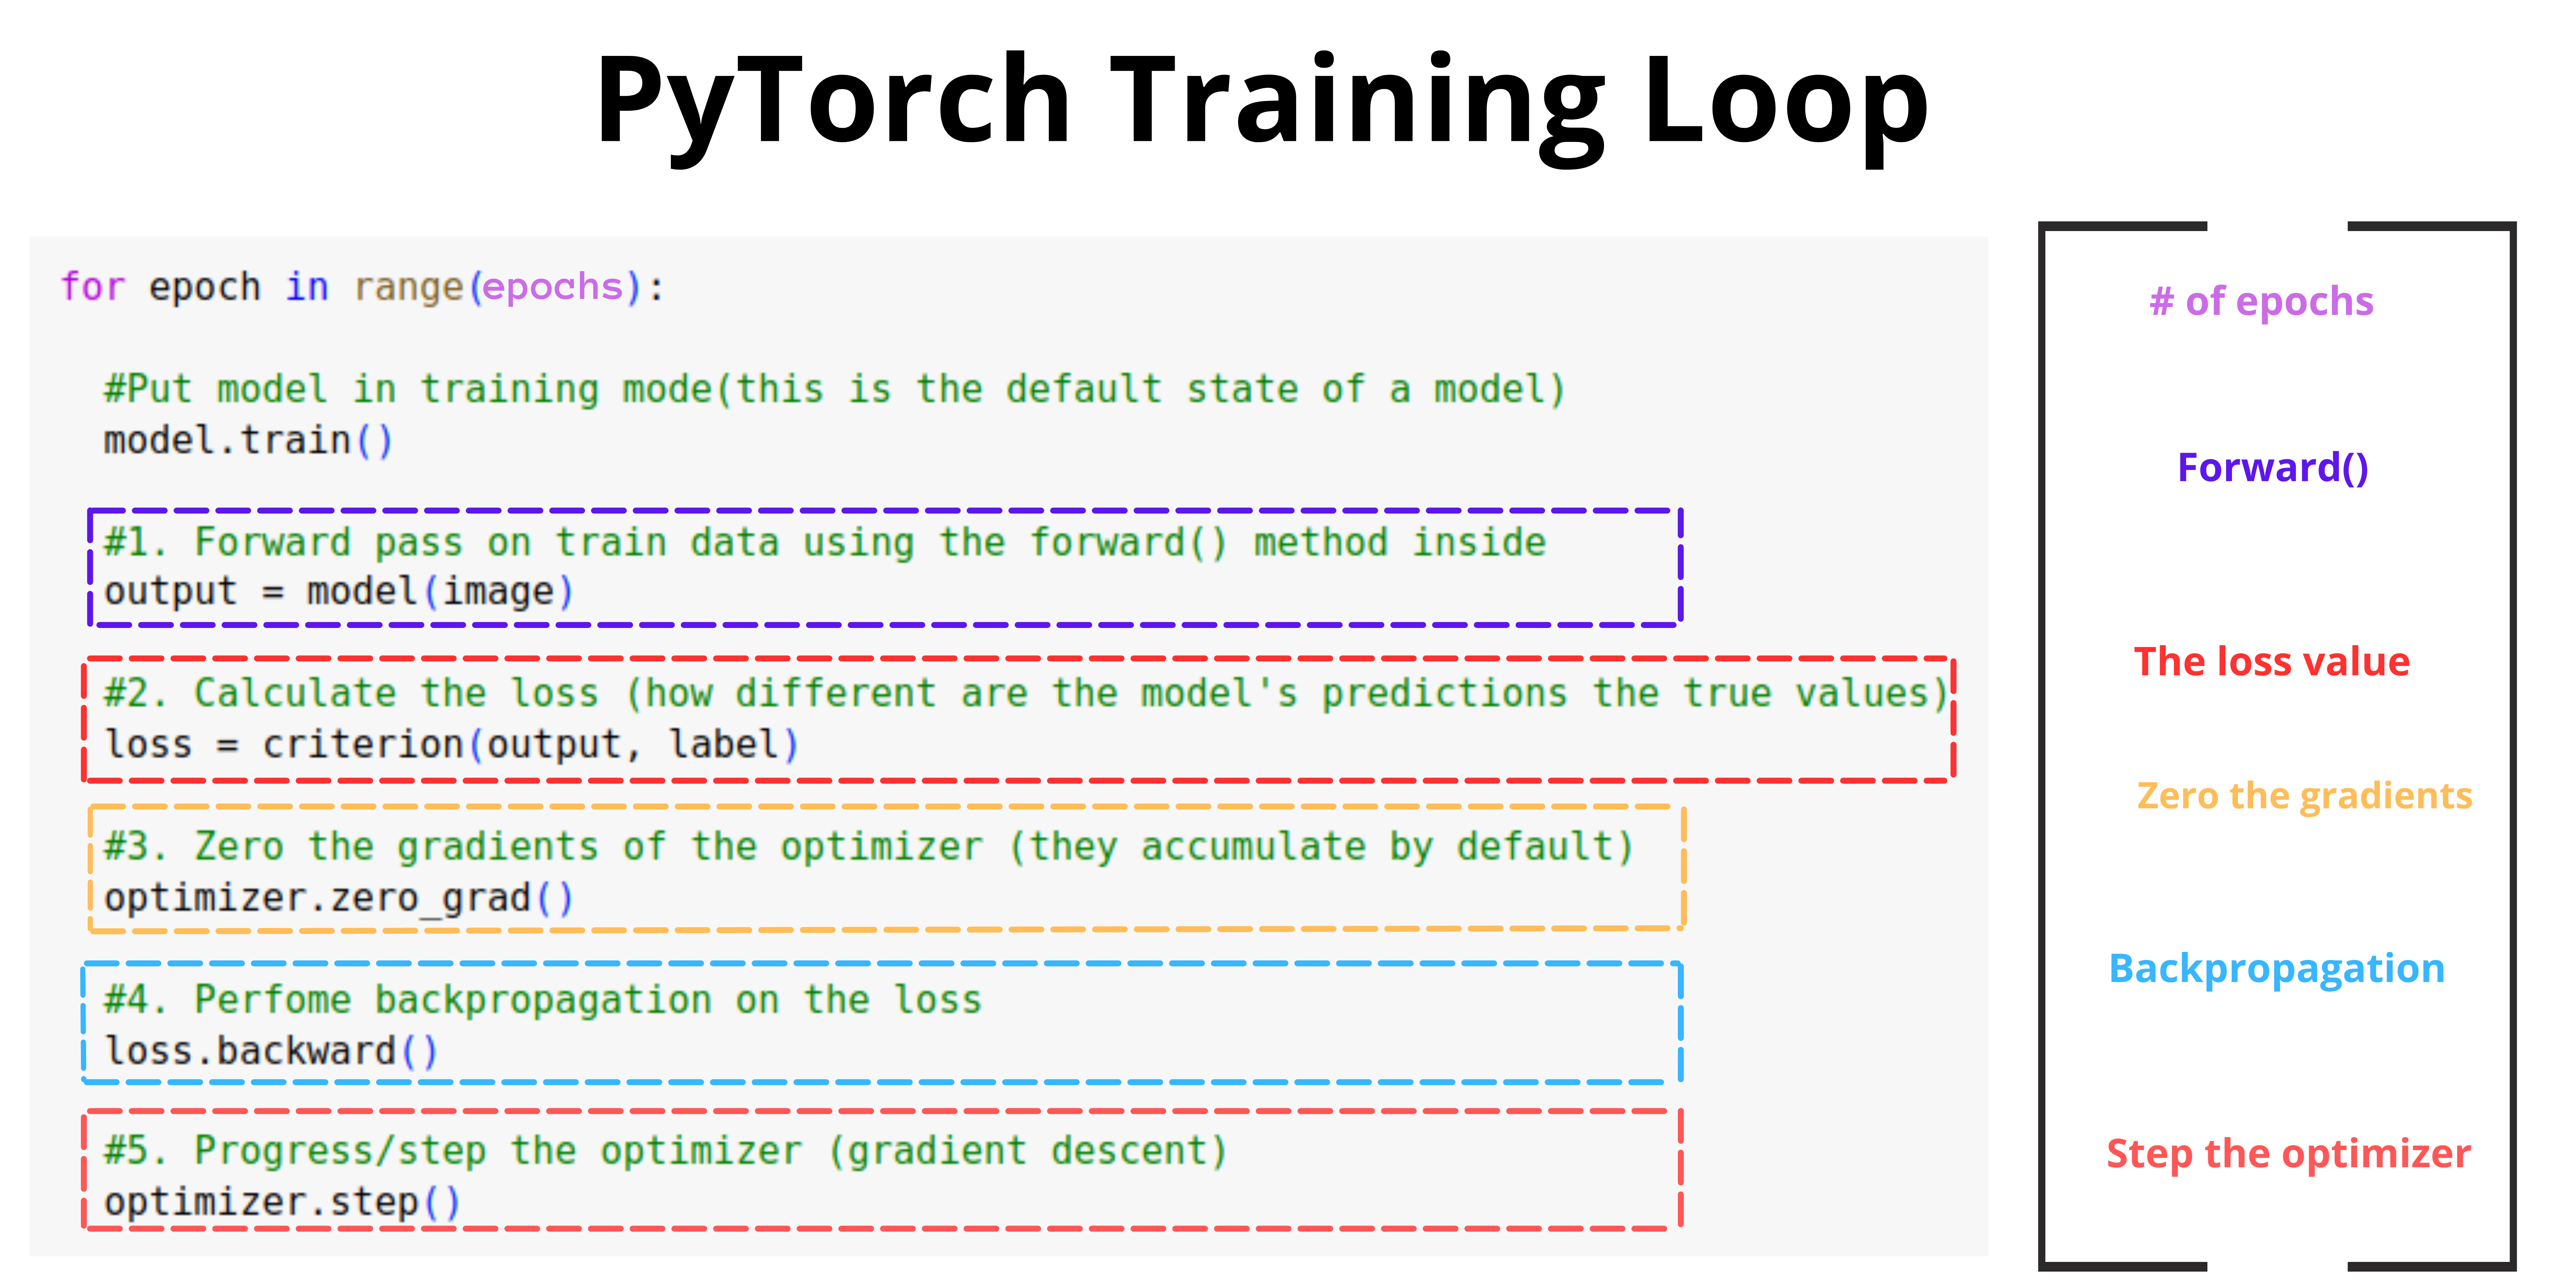


In [ ]:
def train(train_loader, model, criterion, optimizer, epoch, verbose=True):
    random.shuffle(train_loader)

    print('Starting training epoch {}'.format(epoch))
    model.train()
    scaler = torch.cuda.amp.GradScaler()

    batch_time, data_time, losses, top1 = AverageMeter(), AverageMeter(), AverageMeter(), AverageMeter()

    end = time.time()

    for i, (image, label) in enumerate(train_loader):
        optimizer.zero_grad()

        image, label = image.to(device), label.to(device)

        data_time.update(time.time() - end)

        with torch.cuda.amp.autocast(dtype=torch.float16):
          output = model(image)
          loss = criterion(output, label)

        losses.update(loss.item(), image.size(0))

        # measure accuracy and record loss
        prec1 = accuracy(output.data, label, topk=(1,))[0].item()

        top1.update(prec1, image.size(0))


        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % 50 == 0 and verbose:

            print(f'Epoch: [{epoch}][{i}/{len(train_loader)}]\t'
                f'Time {batch_time.vals[-1]:.3f} ({batch_time.avg:.3f})\t'
                f'Data {data_time.vals[-1]:.3f} ({data_time.avg:.3f})\t'
                f'Loss {losses.vals[-1]:.4f} ({losses.avg:.4f})\t'
                f'Accuracy {top1.vals[-1]:.3f} ({top1.avg:.3f})')


    return losses.vals, top1.vals

## 5. Train the network on the training data


Given a set of images and labels $\{ \textbf{x}^{(i)}, \textbf{y}^{(i)} \}_{i}^{N}$ the procedure to obtain optimal network parameters $\theta^*$ given a neural network architecture $\mathcal{M}_\theta$ can be defined as

$$
\theta^* = \underset{\theta}{\text{arg min}} \quad \mathcal{L}_{ce}(\textbf{y}, \underbrace{\mathcal{M}_\theta(\textbf{x})}_{\hat{\textbf{y}}} )
$$

## Define optimizer




### Gradient Descent (GD)

Gradient Descent is an optimization algorithm for finding a local minimum of a differentiable function. Gradient descent in machine learning and deep learning is simply used to find the values of a function's parameters (coefficients) that minimize a cost function as far as possible.

$$
\theta^{(k+1)} = \theta^{(k)} - \eta \frac{\partial \mathcal{L}_{ce}}{\partial θ}
$$



*   $\theta$ are the network **trainable** parameters
*   $\eta$ is the learning rate



important to consider: toch.optim

Ejemplos optimizadores
Parametros comunes de los optimizadores (learning rate, weight_decay)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Move model and loss function to GPU to accelerate computation
criterion = criterion.to(device)
model = model.to(device)

In [ ]:
# train model for 1000 epochs

epochs = 2
history = {
    'loss': [],
    'acc': [],
    'val_loss': [],
    'val_acc': [],
    'name': ""
}

for epoch in range(epochs):

    losses, acc = train(train_data, model, criterion, optimizer, epoch)

    with torch.no_grad():
        val_loss, val_acc = validate(test_data, model, criterion)

    history['loss'].extend(losses)
    history['acc'].extend(acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)


history['name'] = 'model 1'

Starting training epoch 0
Epoch: [0][0/98]	Time 7.756 (7.756)	Data 0.003 (0.003)	Loss 2.3071 (2.3071)	Accuracy 10.352 (10.352)
Epoch: [0][50/98]	Time 0.032 (0.180)	Data 0.002 (0.003)	Loss 2.1505 (2.2131)	Accuracy 32.617 (24.682)
Test: 	Time 0.036 (0.021)	Data 0.000 (0.000)	Loss 2.0327 (2.0387)	Accuracy 44.643 (44.720)
Starting training epoch 1
Epoch: [1][0/98]	Time 0.045 (0.045)	Data 0.007 (0.007)	Loss 2.0100 (2.0100)	Accuracy 48.242 (48.242)
Epoch: [1][50/98]	Time 0.013 (0.016)	Data 0.002 (0.002)	Loss 1.9777 (2.0032)	Accuracy 51.953 (48.924)
Test: 	Time 0.013 (0.018)	Data 0.000 (0.000)	Loss 1.9321 (1.9313)	Accuracy 55.102 (56.410)


In [ ]:
# this is just for test
# ignore this cell

epochs = 2
history_2 = {
    'loss': [],
    'acc': [],
    'val_loss': [],
    'val_acc': [],
    'name': ""
}

for epoch in range(epochs):

    losses, acc  = train(train_data, model, criterion, optimizer, epoch)

    with torch.no_grad():
        val_loss, val_acc = validate(test_data, model, criterion)

    history_2['loss'].extend(losses)
    history_2['acc'].extend(acc)
    history_2['val_loss'].append(val_loss)
    history_2['val_acc'].append(val_acc)

history_2['name'] = 'model 2'#model.__class__.__name__

Starting training epoch 0
Epoch: [0][0/98]	Time 0.016 (0.016)	Data 0.003 (0.003)	Loss 1.9136 (1.9136)	Accuracy 58.789 (58.789)
Epoch: [0][50/98]	Time 0.018 (0.015)	Data 0.002 (0.002)	Loss 1.9058 (1.9133)	Accuracy 58.398 (57.678)
Test: 	Time 0.013 (0.018)	Data 0.000 (0.000)	Loss 1.9069 (1.9036)	Accuracy 56.505 (57.930)
Starting training epoch 1
Epoch: [1][0/98]	Time 0.016 (0.016)	Data 0.003 (0.003)	Loss 1.8881 (1.8881)	Accuracy 59.375 (59.375)
Epoch: [1][50/98]	Time 0.013 (0.013)	Data 0.002 (0.002)	Loss 1.9077 (1.8657)	Accuracy 56.836 (62.203)
Test: 	Time 0.013 (0.018)	Data 0.000 (0.000)	Loss 1.8613 (1.8566)	Accuracy 62.755 (62.700)


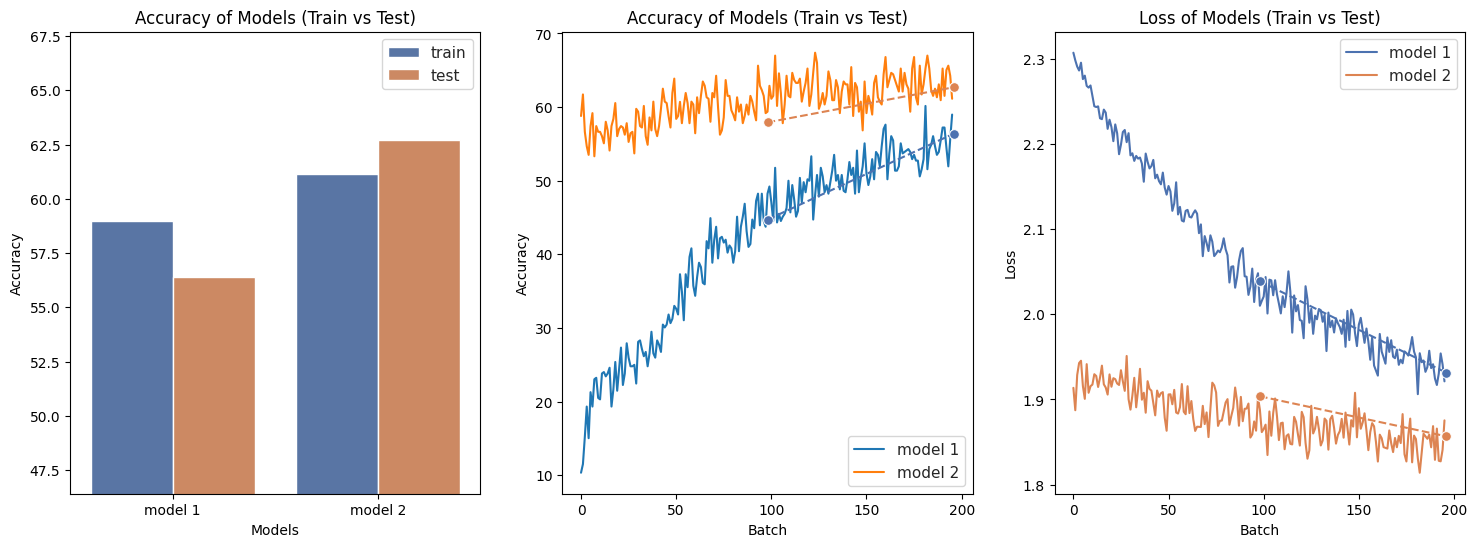

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

acc_barplot(np.array([history,history_2]), ax1)
batch_lineplot(np.array([history,history_2]), ax2)
batch_lineplot(np.array([history,history_2]), ax3, acc=False)

In [ ]:
#@title Tunning Model Function
def tuning_model(parameter_val, epochs, train_data, test_data, optimizer = None,  model = ClassificationNet(), batch=None ):
    """
    this is an auxiliar function to tune hyperparameters of a model
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001) if optimizer is None else optimizer

    criterion = nn.CrossEntropyLoss()
    criterion = criterion.to(device)
    model = model.to(device)

    history = {
        'loss': [],
        'acc': [],
        'val_loss': [],
        'val_acc': [],
        'name': ""
    }

    for epoch in range(epochs):

        losses, acc  = train(train_data, model, criterion, optimizer, epoch, verbose=False)

        with torch.no_grad():
            val_loss, val_acc = validate(test_data, model, criterion)

        if batch:
          acc = [np.mean(acc)]

        history['loss'].extend(losses)
        history['acc'].extend(acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

    history['name'] = str(parameter_val)

    if isinstance(parameter_val, torch.optim.Optimizer):
        history['name'] = parameter_val.__class__.__name__

    return history

### **Batch-size**


The batch size determines **how many examples are used** together before adjusting the model. Experiments show that using a bigger batch often makes the model perform worse in terms of its ability to understand new things. Picking the right batch size involves carefully finding a balance between how training works and how well the model does. When the batch size gets larger, it can make training more steady and use the computer's power better. However, this might also make the model not as good at understanding new samples, which could lead to it fitting too closely to the training data and not being able to find new patterns in new data.

<div align="center"><img src="https://editor.analyticsvidhya.com/uploads/58182variations_comparison.png" width="700" ></div>



**Low Batch Size**

* **Erratic Gradients:** Gradients dance unpredictably with sparse data.

* **Faster Convergence** Early On: An energetic sprint through initial epochs.

* **Inefficient Hardware Use:** Hardware power underutilized, like a thoroughbred held back.

**Large Batch Size**

* **Smooth Gradients**: Gradients glide steadily, painting a smoother optimization path.

* **Slower Convergence:** A patient marathon, progressing with measured steps.

* **Memory Efficiency:** Hardware harmonized, orchestrating a symphony of efficient computation.

* **Potential Overfitting:** The risk of over-memorization lurks in the vast data expanse.

* **Limited Exploration:** A narrow journey, missing the landscapes of alternative solutions.

Starting training epoch 0
Test: 	Time 0.015 (0.021)	Data 0.000 (0.000)	Loss 1.8787 (1.8796)	Accuracy 59.694 (59.410)
Starting training epoch 1
Test: 	Time 0.015 (0.021)	Data 0.000 (0.000)	Loss 1.8360 (1.8268)	Accuracy 62.883 (64.410)
Starting training epoch 2
Test: 	Time 0.018 (0.024)	Data 0.000 (0.000)	Loss 1.8165 (1.8077)	Accuracy 63.520 (65.730)
Starting training epoch 3
Test: 	Time 0.013 (0.020)	Data 0.000 (0.000)	Loss 1.8208 (1.8011)	Accuracy 63.265 (66.280)
Starting training epoch 4
Test: 	Time 0.015 (0.021)	Data 0.000 (0.000)	Loss 1.8221 (1.8023)	Accuracy 64.158 (66.140)
Starting training epoch 5
Test: 	Time 0.016 (0.023)	Data 0.000 (0.000)	Loss 1.7946 (1.7743)	Accuracy 66.582 (68.980)
Starting training epoch 6
Test: 	Time 0.016 (0.021)	Data 0.000 (0.000)	Loss 1.7871 (1.7698)	Accuracy 67.602 (69.180)
Starting training epoch 7
Test: 	Time 0.015 (0.022)	Data 0.000 (0.000)	Loss 1.7943 (1.7686)	Accuracy 66.071 (69.300)
Starting training epoch 0
Test: 	Time 0.014 (0.026)	Data 0.000 (

Text(0.5, 0, 'epochs')

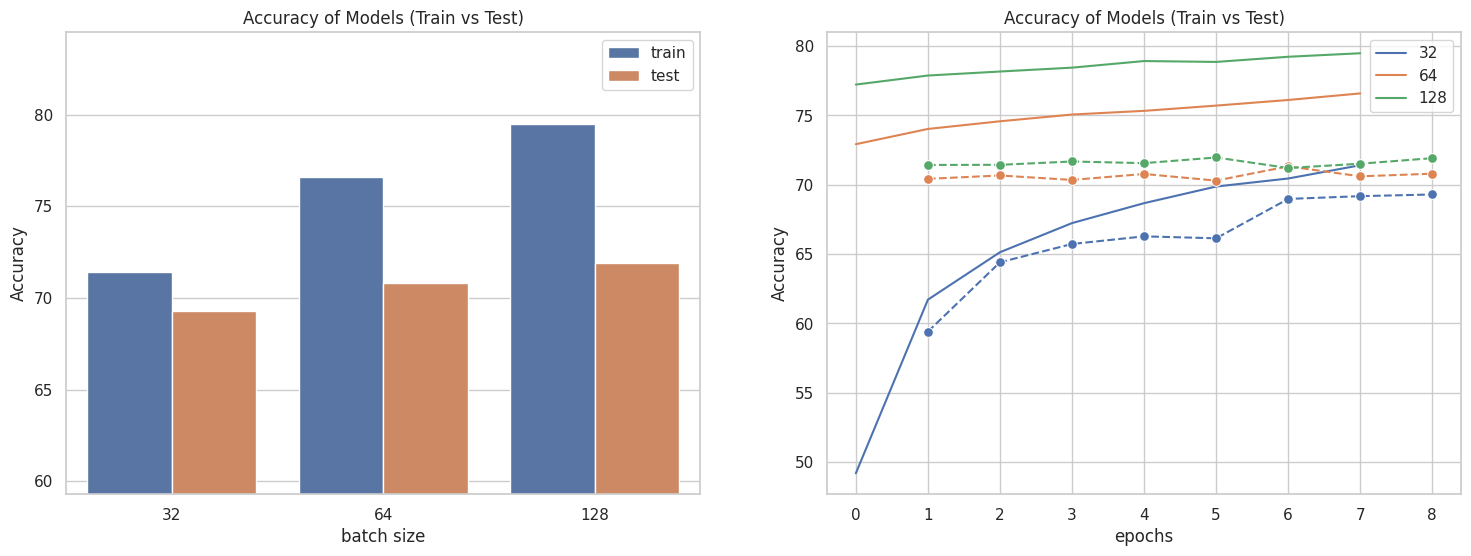

In [ ]:
batch_size_1 = 32   # @param {type:"integer"}
batch_size_2 = 64  # @param {type:"integer"}
batch_size_3 = 128 # @param {type:"integer"}

batch_sizes = [ batch_size_1, batch_size_2, batch_size_3 ]

historys = []

for batch_size in batch_sizes:
        train_data, test_data = load_data(batch_size=batch_size)
        history = tuning_model(batch_size, 8, train_data, test_data, batch=True)
        historys.append(history)


# plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

acc_barplot(np.array(historys), ax1, 'batch size')
batch_lineplot(np.array(historys), ax = ax2)
ax2.set_xlabel('epochs')

### learning rate tuning

The learning rate is a hyperparameter that controls how quickly the model learns and adapts to the problem during training. Choosing the right learning rate is important for making sure the model converges efficiently to an optimal solution.

<div align="center"><img src="https://i.imgur.com/1ZPQw1l.png" width="700" ></div>


- **Low Learning Rate**
    - Training progresses very slowly
    - Loss function decreases gently
    - Model may get stuck in suboptimal solution

- **High Learning Rate** 
    - Training may diverge and become unstable
    - Loss function oscillates and diverges
    - Model struggles to converge to optimal solution
    
The ideal learning rate is problem-specific and depends on factors like the neural network architecture, complexity of the problem, and size of the dataset. It is common practice to gradually decrease the learning rate as training progresses to allow for more fine-tuned learning in later epochs.


In [ ]:
learning_rate_1 = 1e-3 # @param {type:"number"}
learning_rate_2 = 1e-2 # @param {type:"number"}
learning_rate_3 = 1e-1 # @param {type:"number"}


lrs = [learning_rate_1, learning_rate_2, learning_rate_3]

historys = []
train_data, test_data = load_data(batch_size=512)


for lr in lrs:
            model = ClassificationNet()
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            history = tuning_model(lr, 10, train_data, test_data, optimizer, model)
            historys.append(history)


Starting training epoch 0
Test: 	Time 0.014 (0.018)	Data 0.000 (0.000)	Loss 2.0433 (2.0534)	Accuracy 45.281 (44.700)
Starting training epoch 1
Test: 	Time 0.013 (0.018)	Data 0.000 (0.000)	Loss 1.9412 (1.9475)	Accuracy 54.847 (54.760)
Starting training epoch 2
Test: 	Time 0.014 (0.018)	Data 0.000 (0.000)	Loss 1.8928 (1.8937)	Accuracy 58.291 (58.540)
Starting training epoch 3
Test: 	Time 0.014 (0.018)	Data 0.000 (0.000)	Loss 1.8815 (1.8723)	Accuracy 59.056 (60.210)
Starting training epoch 4
Test: 	Time 0.014 (0.019)	Data 0.000 (0.000)	Loss 1.8680 (1.8582)	Accuracy 60.077 (61.620)
Starting training epoch 5
Test: 	Time 0.013 (0.018)	Data 0.000 (0.000)	Loss 1.8385 (1.8283)	Accuracy 63.393 (64.970)
Starting training epoch 6
Test: 	Time 0.013 (0.018)	Data 0.000 (0.000)	Loss 1.8274 (1.8192)	Accuracy 64.796 (65.460)
Starting training epoch 7
Test: 	Time 0.014 (0.018)	Data 0.000 (0.000)	Loss 1.8363 (1.8170)	Accuracy 64.031 (65.370)
Starting training epoch 8
Test: 	Time 0.014 (0.018)	Data 0.000 (

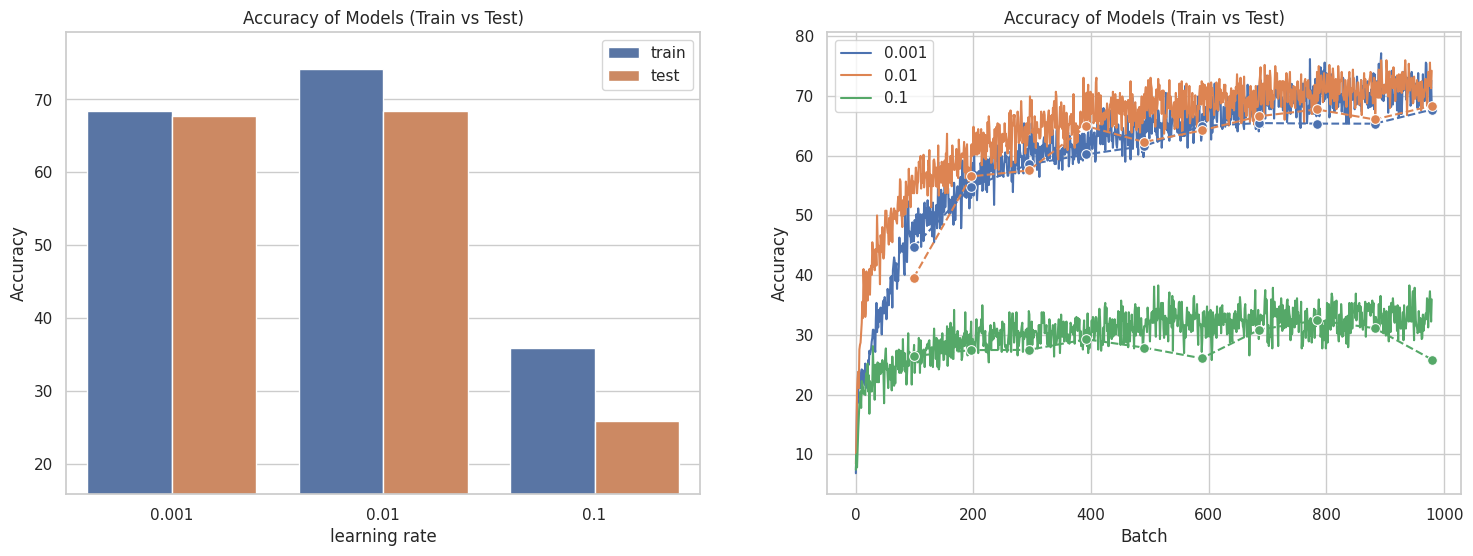

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

acc_barplot(np.array(historys), ax1, 'learning rate')
batch_lineplot(np.array(historys), ax = ax2)

### optimizer tuning

Starting training epoch 0
Test: 	Time 0.014 (0.020)	Data 0.000 (0.000)	Loss 1.9131 (1.9216)	Accuracy 54.082 (54.260)
Starting training epoch 1
Test: 	Time 0.013 (0.018)	Data 0.000 (0.000)	Loss 1.8823 (1.8755)	Accuracy 58.291 (58.570)
Starting training epoch 2
Test: 	Time 0.013 (0.018)	Data 0.000 (0.000)	Loss 1.8648 (1.8430)	Accuracy 59.184 (61.810)
Starting training epoch 3
Test: 	Time 0.013 (0.018)	Data 0.000 (0.000)	Loss 1.8340 (1.8335)	Accuracy 63.520 (62.760)
Starting training epoch 4
Test: 	Time 0.014 (0.018)	Data 0.000 (0.000)	Loss 1.8473 (1.8324)	Accuracy 61.735 (62.630)
Starting training epoch 0
Test: 	Time 0.013 (0.018)	Data 0.000 (0.000)	Loss 2.2840 (2.2882)	Accuracy 17.602 (16.210)
Starting training epoch 1
Test: 	Time 0.013 (0.018)	Data 0.000 (0.000)	Loss 2.2635 (2.2695)	Accuracy 20.663 (18.620)
Starting training epoch 2
Test: 	Time 0.014 (0.018)	Data 0.000 (0.000)	Loss 2.2410 (2.2499)	Accuracy 21.429 (20.030)
Starting training epoch 3
Test: 	Time 0.013 (0.022)	Data 0.000 (

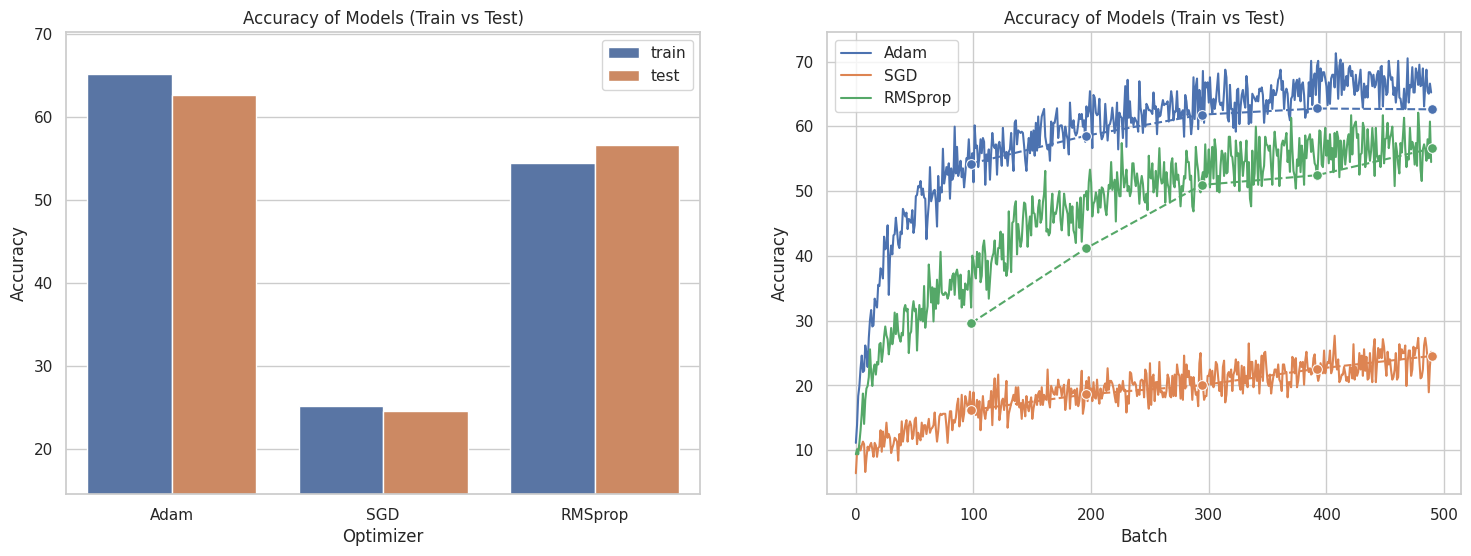

In [ ]:
optim_dict = {
    "Adam": torch.optim.Adam,
    "SGD": torch.optim.SGD,
    "RMSprop": torch.optim.RMSprop,
    "Adadelta": torch.optim.Adadelta,
}


optimizer_1 = "Adam" # @param ["Adam", "SGD", "RMSprop", "Adadelta"]
optimizer_2 = "SGD"  # @param ["Adam", "SGD", "RMSprop", "Adadelta"]
optimizer_3 = "RMSprop"  # @param ["Adam", "SGD", "RMSprop", "Adadelta"]



optimizers = [  optim_dict[optimizer_1], optim_dict[optimizer_2], optim_dict[optimizer_3] ]

historys = []
train_data, test_data = load_data(batch_size=512)

for optimizer in optimizers:
    model = ClassificationNet()
    optimizer = optimizer(model.parameters(), lr=0.01)
    history = tuning_model(optimizer, 5, train_data, test_data, optimizer, model)
    historys.append(history)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
acc_barplot(np.array(historys), ax1, 'Optimizer')
batch_lineplot(np.array(historys), ax = ax2)


## model size comparison

Choosing the right model size involves tradeoffs between computational resources and model performance. Larger models tend to have higher capacity but are more resource intensive to train.



<div align="center"><img src="https://www.researchgate.net/profile/Brian-Davison/publication/339139382/figure/fig2/AS:856873737674754@1581306027943/Top-1-accuracy-versus-network-size-and-parameters-D201-Densenet201-Iv3-Inceptionv3.ppm" width="400" ></div>


- **Tiny Model**
    - Very low computational requirements
    - Lower model capacity 
    - May struggle to fit complex patterns

- **Small Model**
    - Low computational requirements
    - Reasonable model capacity
    - Can fit moderately complex patterns

- **Medium Model**
    - Moderate computational requirements
    - Good model capacity
    - Can fit more complex patterns 

- **Large Model**
    - High computational requirements
    - Very high model capacity
    - Can fit extremely complex patterns
    - Risk of overfitting due to high capacity

The optimal model size depends on the problem complexity, amount of training data, and available computational resources. Smaller models train faster while larger models can fit more intricate patterns. The model size should be chosen to provide a good balance.

In [ ]:
tiny = ClassificationNet(features = 8, num_layers = 4, name = "tiny")

small = ClassificationNet(features = 16, num_layers = 4, name = "small")

medium = ClassificationNet(features = 32, num_layers = 4, name = "medium")

large = ClassificationNet(features = 64, num_layers = 4, name = "large")

models = [ tiny, small, medium, large ]

In [ ]:
historys = []
train_data, test_data = load_data(batch_size=512)

for model in models:
    history = tuning_model(model.name, 5, train_data, test_data,model= model)
    historys.append(history)

Starting training epoch 0
Test: 	Time 0.011 (0.007)	Data 0.000 (0.000)	Loss 2.1499 (2.1531)	Accuracy 34.566 (32.310)
Starting training epoch 1
Test: 	Time 0.005 (0.006)	Data 0.000 (0.000)	Loss 2.0561 (2.0662)	Accuracy 44.643 (42.230)
Starting training epoch 2
Test: 	Time 0.005 (0.006)	Data 0.000 (0.000)	Loss 2.0059 (2.0258)	Accuracy 48.980 (45.650)
Starting training epoch 3
Test: 	Time 0.005 (0.007)	Data 0.000 (0.000)	Loss 1.9803 (1.9994)	Accuracy 50.383 (47.690)
Starting training epoch 4
Test: 	Time 0.005 (0.006)	Data 0.000 (0.000)	Loss 1.9661 (1.9804)	Accuracy 51.403 (49.630)
Starting training epoch 0
Test: 	Time 0.014 (0.018)	Data 0.000 (0.000)	Loss 2.0455 (2.0565)	Accuracy 45.791 (44.460)
Starting training epoch 1
Test: 	Time 0.014 (0.018)	Data 0.000 (0.000)	Loss 1.9614 (1.9633)	Accuracy 52.423 (52.700)
Starting training epoch 2
Test: 	Time 0.013 (0.018)	Data 0.000 (0.000)	Loss 1.9274 (1.9226)	Accuracy 54.592 (56.020)
Starting training epoch 3
Test: 	Time 0.014 (0.018)	Data 0.000 (

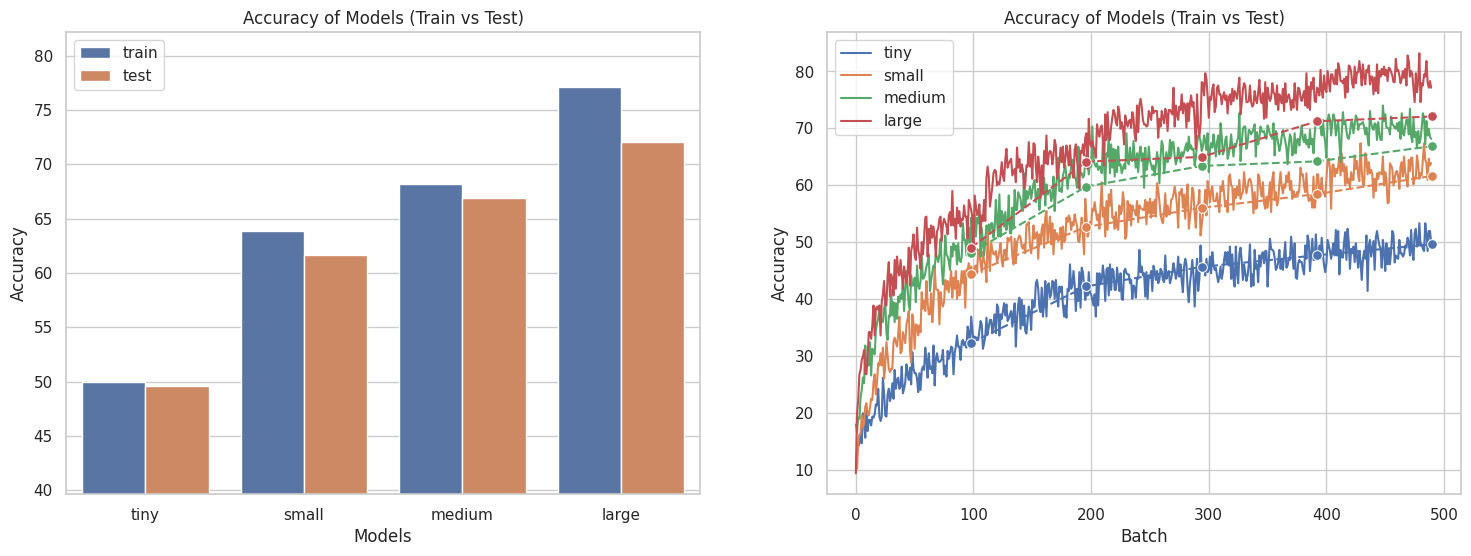

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

acc_barplot(np.array(historys), ax = ax1)
batch_lineplot(np.array(historys), ax = ax2)